In [2]:
# run only first time
# %pip install -q numpy scipy librosa soundfile  matplotlib 

In [3]:
import json
import numpy as np
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio, display

def to_mono(x):
    return x if x.ndim == 1 else np.mean(x, axis=1)

def rms(x, eps=1e-12):
    return float(np.sqrt(np.mean(np.square(x), dtype=np.float64) + eps))

def normalize_peak(x, peak=0.99, eps=1e-12):
    m = np.max(np.abs(x)) + eps
    return x if m <= peak else x * (peak / m)

def pick_noise_segment(noise, need_len, mode="random", seed=None):
    """
    Returns a noise segment of exact length 'need_len'.
    If noise is shorter, it is looped; if longer, it's cropped per `mode`.
    """
    rng = np.random.default_rng(seed)
    if len(noise) == need_len:
        return noise.copy()
    if len(noise) > need_len:
        if mode == "head":
            return noise[:need_len]
        if mode == "tail":
            return noise[-need_len:]
        start = int(rng.integers(0, len(noise) - need_len + 1))
        return noise[start:start+need_len]
    # loop if too short
    reps = int(np.ceil(need_len / len(noise)))
    return np.tile(noise, reps)[:need_len]

def match_snr(speech, noise, snr_db):
    """
    Scale `noise` such that 20*log10(rms(speech)/rms(noise_scaled)) = snr_db.
    """
    rs, rn = rms(speech), rms(noise)
    if rn < 1e-12:
        return noise
    target_rn = rs / (10 ** (snr_db / 20.0))
    scale = target_rn / rn
    return noise * scale


In [4]:
def mix_speech_and_noise(
    speech_path: str,
    noise_path: str,
    out_path: str = "mixture.wav",
    sr: int = 16000,
    snr_db: float = 5.0,
    head_sec: float = 0.6,
    tail_sec: float = 0.0,
    noise_crop: str = "random",  # "random" | "head" | "tail"
    export_stems: bool = True,
    seed: int = 42,
    show_plots: bool = True,
    autoplay: bool = True,
    save_noise: str = "aligned_noise.wav",
    save_speech: str = "aligned_speech.wav",
):
    """
    Creates a mixture: [noise-only head] + [speech+noise @ SNR] + [noise-only tail]
    speecth_path -> path of speech only sound
    noise_path -> path of noise only sound
    out_path -> path to save the output
    sr -> sample rate of ouput
    snr_db -> target snr of output
    head_sec -> duration of no speech at the begin of output in sec.
    tail_sec -> duration of no speech at the end of output in sec.
    noise_crop -> in case noise sound short than speech which part should use for extend it 
                  head -> begin of noise file
                  tail -> end of noise file
                  random -> random part
    export_stems -> True if want to save speech and noise with new aligned else False
    seed -> seed for random noise_crop if want
    show_plot -> True if want to plot wave form of output
    autoplay -> True if want to play the output file
    save_noise -> path to save new aligned of noise
    save_speech -> path to save new aligned of speech
    Returns (mixture, sr, dict_stats).
    """
    # Load mono at target sr
    s, sr_s = librosa.load(speech_path, sr=sr, mono=True)
    n, sr_n = librosa.load(noise_path,  sr=sr, mono=True)

    # Timeline lengths
    H = int(round(max(0.0, head_sec) * sr))
    T = int(round(max(0.0, tail_sec) * sr))
    total_len = H + len(s) + T

    # Prepare noise track to exact length
    n_seg = pick_noise_segment(n, total_len, mode=noise_crop, seed=seed).astype(np.float32)

    # Make aligned speech (padded with zeros around)
    aligned_s = np.zeros(total_len, dtype=np.float32)
    aligned_s[H:H+len(s)] = s.astype(np.float32)

    # Scale noise on the speech-active window to hit target SNR
    noise_active = n_seg[H:H+len(s)].copy()
    noise_active = match_snr(aligned_s[H:H+len(s)], noise_active, snr_db)
    aligned_n = n_seg
    aligned_n[H:H+len(s)] = noise_active

    # Mix and normalize
    mix = aligned_s + aligned_n
    mix = normalize_peak(mix, peak=0.99)

    # Save files
    sf.write(out_path, mix, sr)
    if export_stems:
        sf.write(save_speech, aligned_s, sr)
        sf.write(save_noise,  aligned_n, sr)

    stats = {
        "sr": sr,
        "duration_s": round(len(mix) / sr, 3),
        "head_sec": head_sec,
        "tail_sec": tail_sec,
        "snr_db_target": float(snr_db),
        "speech_rms": round(rms(aligned_s[H:H+len(s)]), 6),
        "noise_rms_after_scale": round(rms(aligned_n[H:H+len(s)]), 6),
        "peak_after_mix": round(float(np.max(np.abs(mix))), 6),
        "exported_stems": bool(export_stems),
        "out_path": out_path,
    }
    print(json.dumps(stats, indent=2))

    # Optional: quick plots & audio
    if show_plots:
        t = np.arange(total_len) / sr
        fig, ax = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
        ax[0].plot(t, aligned_s, lw=0.8)
        ax[0].set_title("Aligned Speech")
        ax[1].plot(t, aligned_n, lw=0.8)
        ax[1].set_title("Aligned Noise (scaled to target SNR over speech region)")
        ax[2].plot(t, mix, lw=0.8)
        ax[2].set_title("Mixture")
        ax[2].set_xlabel("Time (s)")
        for a in ax: a.grid(True, ls=":")
        plt.tight_layout(); plt.show()

    if autoplay:
        print("▶ Mixture preview:")
        display(Audio(mix, rate=sr))

    return mix, sr, stats


{
  "sr": 16000,
  "duration_s": 16.625,
  "head_sec": 0,
  "tail_sec": 0.0,
  "snr_db_target": -3.0,
  "speech_rms": 0.067938,
  "noise_rms_after_scale": 0.095965,
  "peak_after_mix": 0.545889,
  "exported_stems": true,
  "out_path": "mix_data/test-4-l1-3db.wav"
}


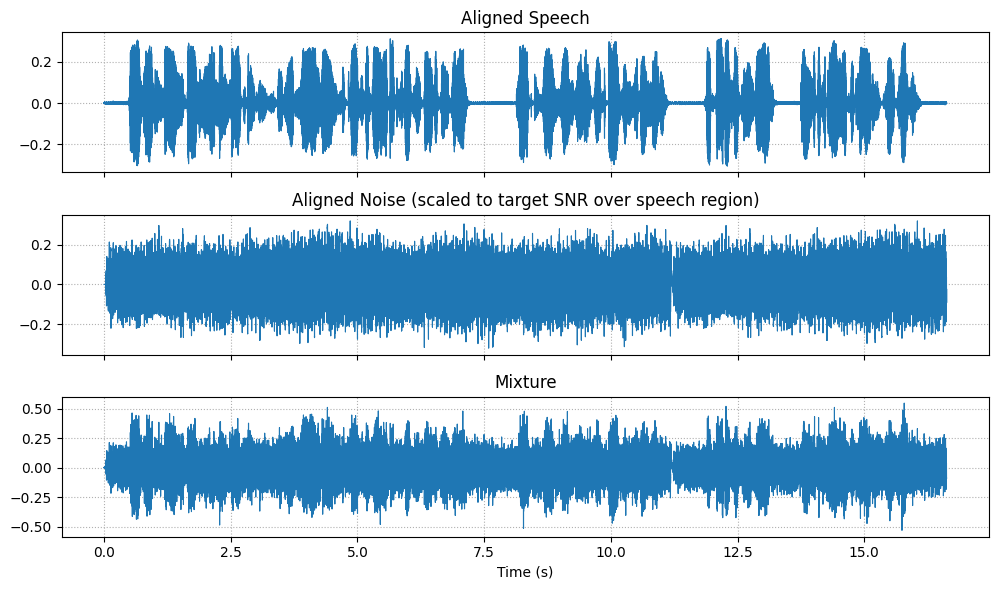

▶ Mixture preview:


In [ ]:
speech_path = ""    
noise_path  = ""

mix, sr_out, stats = mix_speech_and_noise(
            speech_path,
            noise_path,
            head_sec=0,
            snr_db=-3,
            export_stems=True,
            out_path="",
            save_speech="",
            save_noise=""
        )

In [6]:
# generate test file
# speech_path = ""     # <-- replace
# 

# for level in range(1,4):
#     noise_path  = f"./sample-sound/fan{level}-2.wav"
#     for db in range(-3,4):
#         mix, sr_out, stats = mix_speech_and_noise(
#             speech_path,
#             noise_path,
#             snr_db=db,
#             out_path=f"./mix_data/ml_{level}_{db}dB.wav",
#             save_speech=f"./speech_data/sl_{level}_{db}dB.wav",
#             save_noise=f"./noise_data/nl_{level}_{db}dB.wav",
#             autoplay=False,
#             show_plots=False
#         )
